# Flight Cancellation Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

## Introduction

### Topic

This is a project about analyzing a flight data dataset. The dataset given by a travel agency is comprised of information about a single flight such as month, departure time, distance, etc as well as one column indicating whether the flight is canceled or not. Our task is to come up with a model that will give predictions about whether a flight is going to be canceled based on above information of the flight. Also, since the agency only sells tickets for three airlines (AA,UA, and DL), we need to give an analysis on which airline has the least risk of cancellation.

### Data 

Field            | Name Type | Description
-----------------|-----------|----------------------------------
Canceled         | Binary    | Canceled = 1
Month            | Integer   | Jan = 1
DepartureTime    | Integer   | Military Time (1:00 PM = 1300)
UniqueCarrier    | String    | Airline Carrier Code
SchedElapsedTime | Integer   | Scheduled Flight time in minutes
ArrDelay         | Integer   | Arrival delay in minutes
DepDelay         | Integer   | Departure delay in minutes
Distance         | Integer   | Distance in miles

First, let's take an overview of the dataset.

In [2]:
# Load dataset 
FlightDelay = pd.read_csv('FlightDelays_Data_3.0.csv')
FlightDelay.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1.0,12,814,UA,134.0,0.0,0,679.0
1,1.0,12,830,DL,90.0,0.0,0,214.0
2,1.0,1,1835,UA,213.0,0.0,0,1605.0
3,1.0,4,1730,AA,80.0,0.0,0,235.0
4,1.0,7,1442,UA,103.0,0.0,0,413.0


In [3]:
FlightDelay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
Canceled            5999 non-null float64
Month               6000 non-null int64
DepartureTime       6000 non-null int64
UniqueCarrier       6000 non-null object
SchedElapsedTime    5998 non-null float64
ArrDelay            5999 non-null float64
DepDelay            6000 non-null int64
Distance            5999 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 375.1+ KB


From above table we could see that there are 8 variables in total. Since we are focusing on predicting whether a ﬂight will be canceled, we would not take variables "ArrDelay" & "DepDelay" into consideration because they could be recorded when the flight is not canceled.

In [4]:
# Drop useless variables
FlightDelay_ = FlightDelay.drop(['ArrDelay','DepDelay'], 1)
FlightDelay_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
Canceled            5999 non-null float64
Month               6000 non-null int64
DepartureTime       6000 non-null int64
UniqueCarrier       6000 non-null object
SchedElapsedTime    5998 non-null float64
Distance            5999 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 281.3+ KB


Now, moving on to missing data. From above output, we could see only four columns have one or two missing data. Let's take a look how this missing data distributed.

In [5]:
# Rows with missing data
FlightDelay_[pd.isnull(FlightDelay_).any(axis=1)]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,Distance
189,1.0,12,1415,AA,255.0,NaN
1205,0.0,4,2225,DL,NaN,2586.0
1558,0.0,1,1325,AA,NaN,1235.0
2542,NaN,6,845,UA,85.0,416.0


Considering the missing data only accounts for small part of the data set, we could just remove them.

In [6]:
# Remove missing data
FlightDelay_dropna = FlightDelay_.dropna(axis = 0, how = 'any')

#Change data type of "Canceled" variable to integer
FlightDelay_dropna['Canceled'] = FlightDelay_dropna['Canceled'].astype(int)
FlightDelay_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996 entries, 0 to 5999
Data columns (total 6 columns):
Canceled            5996 non-null int64
Month               5996 non-null int64
DepartureTime       5996 non-null int64
UniqueCarrier       5996 non-null object
SchedElapsedTime    5996 non-null float64
Distance            5996 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 327.9+ KB


In [7]:
FlightDelay_dropna.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,Distance
0,1,12,814,UA,134.0,679.0
1,1,12,830,DL,90.0,214.0
2,1,1,1835,UA,213.0,1605.0
3,1,4,1730,AA,80.0,235.0
4,1,7,1442,UA,103.0,413.0


Now we can dive into Exploratory Data Analysis with the new and more precise data frame we got.

## Exploratory Data Analysis

## Overview

First, let's take a look at how these 8 variables distributed and interact with each other. To achieve this, I used the pairplot function from Seaborn module to plot multiple pairwise distributions.

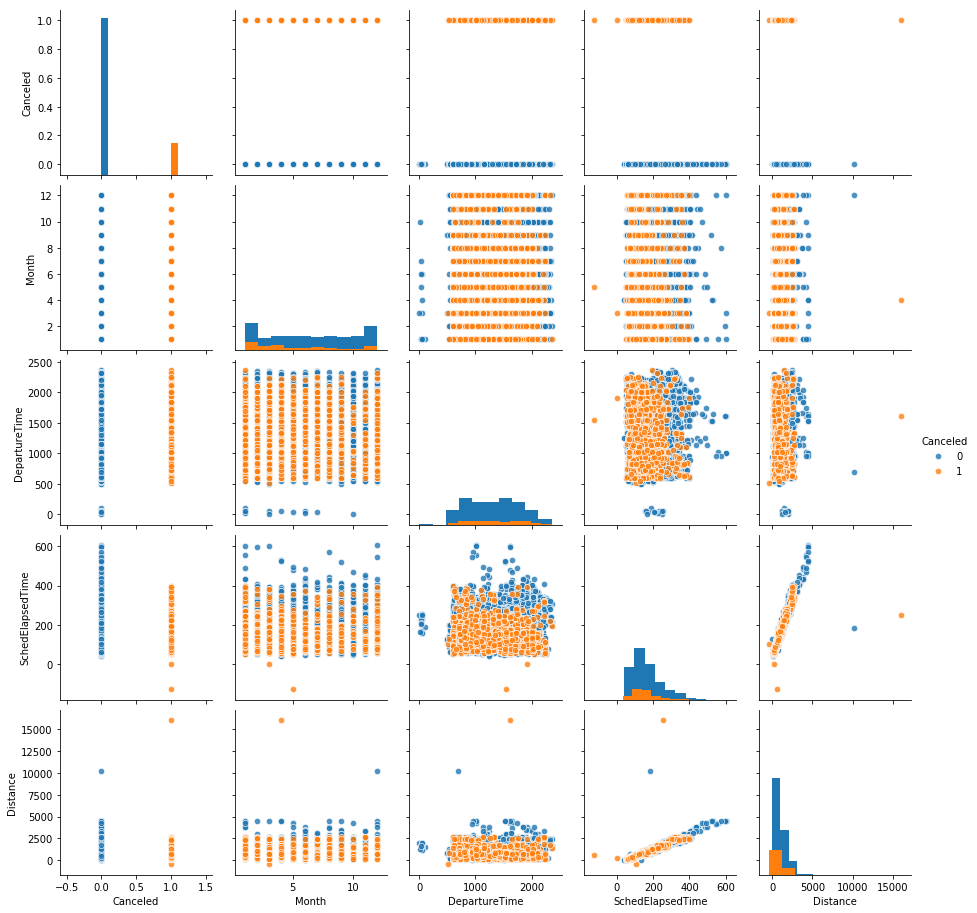

In [8]:
## Multiple pairwise distributions
sns.pairplot(FlightDelay_dropna,hue='Canceled', diag_kind = 'hist',
             vars = ['Canceled','Month','DepartureTime','SchedElapsedTime','Distance'],
                plot_kws = {'alpha': 0.8, 's': 40, 'edgecolor': 'w'})

From the graph above, we could see that: 
1. The first diagonal plots shows that our target variable "Canceled" is imbalanced. The number of "Canceled" flight is around 1/5 of the number of "non-canceled" flight.
2. There seems to be less canceled flights in October and November.
3. There seems to be no obvious relationship between departure time and whether the flight would be canceled.
4. There exists colinearity between 'SchedElapsedTime' and 'Distance'.

We will dive into this obervations one by one, as well as how do the three different carriers - UA, DL & AA perform.

## Most reliable Airline

In order to advise customers on which airline has the least risk of cancellation, let's first plot out the distribution of canceled and non-canceled flight among these three carriers.

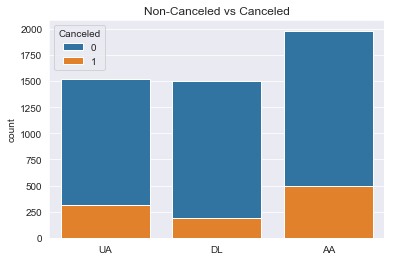

In [9]:
# Plot the distribution of canceled and non-canceled flight among these three carriers
sns.set_style("darkgrid")
sns.despine()
ax = sns.countplot(x="UniqueCarrier", hue="Canceled", dodge = False, data=FlightDelay_dropna)
ax.set_title('Non-Canceled vs Canceled')
ax.set_xlabel('')
plt.show()

Graphically, it shows that AA has the highest number of total flights as well as highest number of canceled flights. DL has the least number of canceled flights. However, I would conduct Chi-squared Test first to see if the relationship is statistically significant. 

In [10]:
# Chi-Square Test of 'UniqueCarrier' and 'Canceled'
carrier_cancel = pd.crosstab(FlightDelay_dropna['UniqueCarrier'],FlightDelay_dropna['Canceled'])
chi2, p, dof, expected = stats.chi2_contingency(carrier_cancel)
print(f"Test Statistic is {chi2:.2f}, P-value is {p}")

Test Statistic is 55.32, P-value is 9.709340774087452e-13


Since the P-value is almost 0, we could reject the null hypothesis that there is no difference between each carrier and canceled flights. So, let's then calculate the numeric cancellation ratio.

In [11]:
# Counts of canceled & non-canceled flight of each carrier
pd.crosstab(FlightDelay_dropna['UniqueCarrier'],FlightDelay_dropna['Canceled'])

Canceled,0,1
UniqueCarrier,,
AA,1982,492
DL,1498,189
UA,1517,318


In [12]:
# Percentage of canceled & non-canceled flight of each carrier
pd.crosstab(FlightDelay_dropna['UniqueCarrier'],
            FlightDelay_dropna['Canceled']).apply(lambda r: round(r/r.sum(),3), axis=1)

Canceled,0,1
UniqueCarrier,,
AA,0.801,0.199
DL,0.888,0.112
UA,0.827,0.173


From the above table, we could see that AA has the hightest cancellation rate--19.9% while DL has the least cancellation rate--11.2%. Thus, I would advise customers that DL has the least risk of cancellation in general.

Another perspective to approach this problem is to take other conditions into consideration when making recommendations. For example, if we take month into consideration, the most trustworthy carrier for Janurary doesn't necessarily still perform well in Feburary. Thus, we can investigate whether other attributes are dependent from carrier when it comes to flight canceleing.

Text(0.5, 1.0, 'Number of Canceled Flights by Carrier and Month')

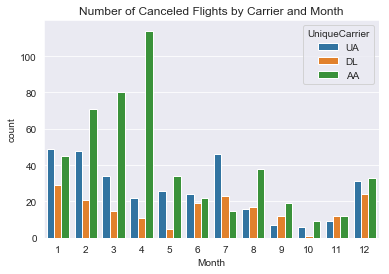

In [35]:
# Get the dataframe of only canceled flights.
FlightDelay_canceled = FlightDelay_dropna.loc[FlightDelay_dropna['Canceled'] == 1]

# Draw the graph of canceled flights of each carrier for every month.
ax = sns.countplot(x='Month',data=FlightDelay_canceled,hue='UniqueCarrier')
ax.set_title('Number of Canceled Flights by Carrier and Month')

In [36]:
# Take month as an exmple. Do Chi-Square Test of 'UniqueCarrier' and 'Month' in dataframe that only has canceled flights.
carrier_cancel = pd.crosstab(FlightDelay_canceled['UniqueCarrier'],FlightDelay_canceled['Month'])
chi2, p, dof, expected = stats.chi2_contingency(carrier_cancel)
print(f"Test Statistic is {chi2:.2f}, P-value is {p}")

Test Statistic is 135.52, P-value is 2.459956011582858e-18


Since the P-value is almost 0, we could reject the null hypothesis that there is no difference between each carrier and month. So, let's then calculate the numeric cancellation ratio for each carrier in every month, and then select the most recommending carrier for every month.

In [37]:
# Calculate the cancel ratio of the each carrier in specific month. Return the carrier with least cancel rate as well as the cancel rate.
def calculate_montly_rate(df_total, df_canceled, month):
    carriers = ["UA", "DL", "AA"]
    df_month_canceled = df_canceled.loc[df_canceled['Month'] == month]
    df_month_total = df_total.loc[df_total['Month'] == month]
    cancel_rates = []
    for carrier in carriers:
        cancel_rates.append(calculate_carrier_number(df_month_canceled, carrier) / calculate_carrier_number(df_month_total, carrier) )
    return carriers[cancel_rates.index(min(cancel_rates))], min(cancel_rates)
    
# Helper function to calculate the number of rows of certain carrier in a dataframe.
def calculate_carrier_number(df, carrier):
    seriesObj = df.apply(lambda x: True if x['UniqueCarrier'] == carrier else False , axis=1)
    numOfRows = len(seriesObj[seriesObj == True].index)
    return numOfRows

for i in range(1, 13):
    carrier, rate = calculate_montly_rate(FlightDelay_dropna, FlightDelay_canceled, i)
    print(f"Recommending carrier in Month {i} is {carrier}, cancel rate is {rate:.2f} ")


Recommending carrier in Month 1 is DL, cancel rate is 0.20 
Recommending carrier in Month 2 is DL, cancel rate is 0.13 
Recommending carrier in Month 3 is DL, cancel rate is 0.11 
Recommending carrier in Month 4 is DL, cancel rate is 0.08 
Recommending carrier in Month 5 is DL, cancel rate is 0.04 
Recommending carrier in Month 6 is AA, cancel rate is 0.11 
Recommending carrier in Month 7 is AA, cancel rate is 0.09 
Recommending carrier in Month 8 is DL, cancel rate is 0.12 
Recommending carrier in Month 9 is UA, cancel rate is 0.05 
Recommending carrier in Month 10 is DL, cancel rate is 0.01 
Recommending carrier in Month 11 is AA, cancel rate is 0.07 
Recommending carrier in Month 12 is DL, cancel rate is 0.14 


## Month vs Canceled

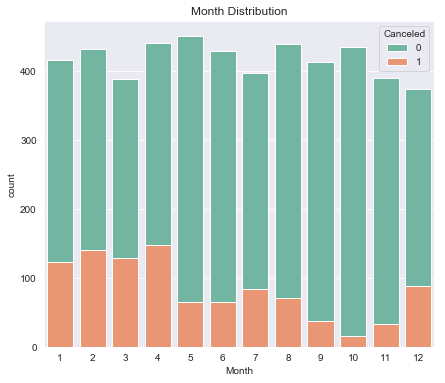

In [13]:
# Plot monthy distribution of canceled and non-canceled flights
plt.figure(figsize=(7,6))
sns.set_style("darkgrid")
sns.despine()
ax = sns.countplot(x="Month", hue="Canceled",dodge = False, data = FlightDelay_dropna, palette="Set2")
ax.set_title('Month Distribution')
plt.show()

From the graph below we could see that there are least amount of canceled flights in October and highest amount of  canceled flights in April. Again, I would conduct Chi-squared Test to see if the relationship between Month and canceled flights is statistically significant.

In [14]:
# Chi-Square Test of 'UniqueCarrier' and 'Canceled'
month_cancel = pd.crosstab(FlightDelay_dropna['Month'],FlightDelay_dropna['Canceled'])
chi2, p, dof, expected = stats.chi2_contingency(month_cancel)
print(f"Test Statistic is {chi2:.2f}, P-value is {p}")

Test Statistic is 212.62, P-value is 1.7799409556004482e-39


Since the P-value is almost 0, we could reject the null hypothesis that there is no difference between each Month and canceled flights. So, I will keep this variable for future prediction model. 

## DepartureTime vs Canceled

Although there seems to be no obvious relationship between departure time and whether the flight would be canceled from pairplot, I need to perform hypothesis test to prove it. I will use t-test here. Since t-test has the assumption that the data, when plotted, results in a normal distribution, bell-shaped distribution curve, I will exam the normality of our data first,

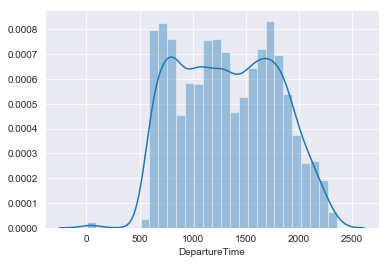

In [15]:
# Plot the distribution of 'DepartureTime'
sns.distplot(FlightDelay_dropna['DepartureTime'])

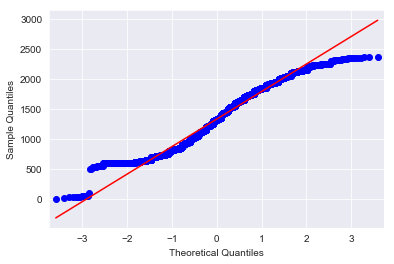

In [16]:
# Plot QQ Plot to exam normality
seed(1)
qqplot(FlightDelay_dropna['DepartureTime'], line='s')
plt.show()

From the above QQ-plot we could see the data is not normally distributed, so I will transform it before conducting t-test

In [17]:
# Transform non-normally distributed data
not_canceled_depart,_ = stats.boxcox(FlightDelay_dropna[FlightDelay_dropna['Canceled'] == 0]["DepartureTime"])
canceled_depart,_ = stats.boxcox(FlightDelay_dropna[FlightDelay_dropna['Canceled'] == 1]["DepartureTime"])

# T-test
tstat,p = stats.ttest_ind(not_canceled_depart, canceled_depart,equal_var=False)

print(f't-statistic is {tstat:.2f} and P-value is {p}')

t-statistic is 21.20 and P-value is 6.406717703172172e-89


Since the P-value is almost 0, we could reject the null hypothesis that there is no relationship between departure time and canceled flights. So, I will keep this variable for future prediction model.

## SchedElapsedTime vs Distance

From the pairplot we could see there exists colinearity between 'SchedElapsedTime' and 'Distance'. Let's calculate the correlation coefficient to be more precised. 

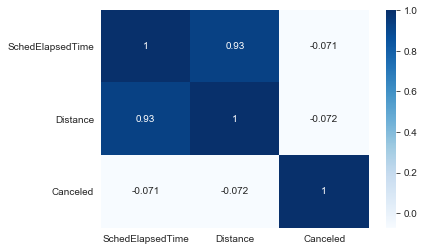

In [18]:
# Calculate correlation coefficient
correlation = FlightDelay_dropna[['SchedElapsedTime','Distance', 'Canceled']].corr()

# Heatmap
sns.heatmap(correlation,annot=True,cmap='Blues')

From above plot we could see the correlation between 'SchedElapsedTime' and 'Distance' is very high -- 0.93, which makes sense because longer distance flights usually will require longer flying time. Also, they both have similar correlation coefficient with canceled flights. Thus, we at most keep one of the two variable for prediction model. So, the question here is, which to keep?

In [19]:
# # Transform non-normally distributed data
# not_canceled_time,_ = stats.boxcox(FlightDelay_dropna[FlightDelay_dropna['Canceled'] == 0]["SchedElapsedTime"])
# canceled_time,_ = stats.boxcox(FlightDelay_dropna[FlightDelay_dropna['Canceled'] == 1]["SchedElapsedTime"])

# # T-test
# tstat,p = stats.ttest_ind(not_canceled_time, canceled_time,equal_var=False)

# print(f't-statistic is {tstat:.2f} and P-value is {p}')

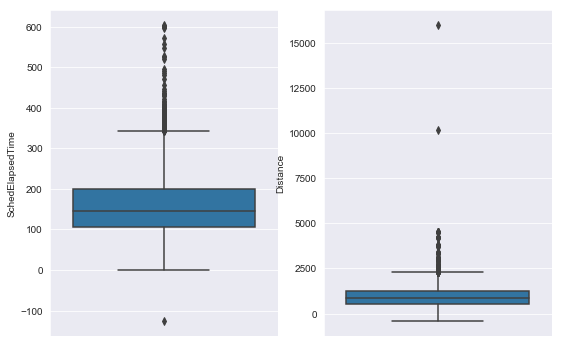

<Figure size 1440x1080 with 0 Axes>

In [20]:
# Boxplot of SchedElapsedTime and Distance
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
plt.figure(figsize=(20,15))
sns.boxplot(FlightDelay_dropna['SchedElapsedTime'], orient='v',ax=axes[0])
sns.boxplot(FlightDelay_dropna['Distance'], orient='v',ax=axes[1])

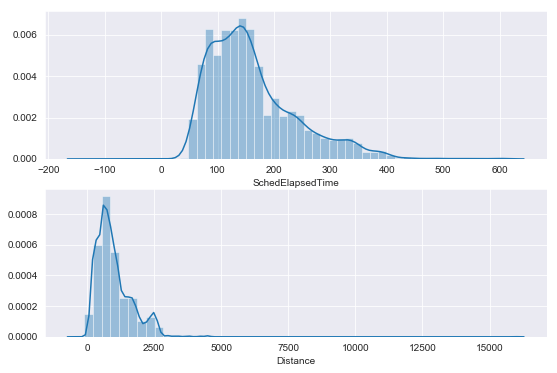

<Figure size 1440x1080 with 0 Axes>

In [21]:
# Distribution plot of SchedElapsedTime and Distance
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9,6))
plt.figure(figsize=(20,15))
sns.distplot(FlightDelay_dropna['SchedElapsedTime'],ax=axes[0])
sns.distplot(FlightDelay_dropna['Distance'],ax=axes[1])

From above boxplot and distribution plot we could see that both of them are not normally distributed. Since 'Distance' is more right skewed than SchedElapsedTime, I decided to keep SchedElapsedTime for future consideration. Then I remove the abnormal data points that have negative or zero SchedElapsedTime to ensure data quality.

In [22]:
# Abnormal data points
FlightDelay_dropna[FlightDelay_dropna['SchedElapsedTime'] <= 0]

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,Distance
67,1,5,1540,UA,-127.0,612.0
106,1,3,1915,AA,0.0,224.0


In [23]:
# Remove abnormal data points
FlightDelay_dropoutliner = FlightDelay_dropna.drop(
                        FlightDelay_dropna[FlightDelay_dropna['SchedElapsedTime'] <= 0].index)

# Feature Selection & Feature Engineering

According to EDA above and in order to build prediction model, I will remove variable 'Distance' and transform 'UniqueCarrier' from categorical data to numerical data by one-hot encoding.  

In [24]:
# Remove variable 'Distance' 
FlightDelay_cleaned = FlightDelay_dropoutliner.drop(['Distance'],axis = 1)
FlightDelay_cleaned.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime
0,1,12,814,UA,134.0
1,1,12,830,DL,90.0
2,1,1,1835,UA,213.0
3,1,4,1730,AA,80.0
4,1,7,1442,UA,103.0


In [25]:
# One hot encode to transform 'UniqueCarrier' 
FlightDelay_encode = pd.get_dummies(FlightDelay_cleaned)
FlightDelay_encode.head()

,Canceled,Month,DepartureTime,SchedElapsedTime,UniqueCarrier_AA,UniqueCarrier_DL,UniqueCarrier_UA
0,1,12,814,134.0,0,0,1
1,1,12,830,90.0,0,1,0
2,1,1,1835,213.0,0,0,1
3,1,4,1730,80.0,1,0,0
4,1,7,1442,103.0,0,0,1


# Prediction Model

## Train-test Split

In [26]:
# Train-test Split
x_variables = FlightDelay_encode.drop(labels=['Canceled'], axis=1)
y_variable = FlightDelay_encode['Canceled']

X_train, X_test, y_train, y_test = train_test_split(x_variables,y_variable,test_size=0.2,random_state=0)
X_train.shape, X_test.shape

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

## Four Different Models

Below we feed the dataset to four different models, and we use classification_report from sklearn to generate all kinds of metrics so that we can evaluate different models. Even though we need to check all metrics thoroughly, we still need to pick certain metrics that we need to pay extra attention to.

For this problem, since the dataset is very unbalanced between canceled and uncanceled flights, the presicion of the model is not a good criteria to evaluate the model. Instead, we need to pay attention to F1 score which is a good combination of precision and recall. Also, we need to take into consideration the results from both micro average and macro average. Since in real life there should be more uncanceled flights than canceled ones, we suspect real-life data would also be unbalanced, similar to what we have for this problem. With this assumption in mind, micro average gives us a good understanding of how the model is going to perform in general. However, on the other hand, we want the model to be good at making predictions for both classes, and macro average is a good indicator for that.

### Logistic Regression

In [27]:
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

## Use 10-fold cross validation to find the the best hyperparameter.
kfold = StratifiedKFold(n_splits=10, random_state=1)
lg_model = LogisticRegressionCV(cv=kfold,class_weight='balanced',random_state=1, solver="liblinear")
lg_model.fit(scaled_X_train,y_train)

print("Results on training set:")
y_pre_train = lg_model.predict(scaled_X_train)
print(classification_report(y_train, y_pre_train))
print("Results on test set:")
y_pre_test = lg_model.predict(scaled_X_test)
print(classification_report(y_test, y_pre_test))

Results on training set:
              precision    recall  f1-score   support

           0       0.89      0.58      0.70      3996
           1       0.24      0.66      0.35       799

   micro avg       0.59      0.59      0.59      4795
   macro avg       0.57      0.62      0.52      4795
weighted avg       0.78      0.59      0.64      4795

Results on test set:
              precision    recall  f1-score   support

           0       0.90      0.58      0.71      1001
           1       0.24      0.68      0.36       198

   micro avg       0.60      0.60      0.60      1199
   macro avg       0.57      0.63      0.53      1199
weighted avg       0.79      0.60      0.65      1199



### SVM

In [28]:
from sklearn.svm import SVC

svm_model = SVC(C=10, gamma=10)
svm_model.fit(scaled_X_train, y_train)

print("Results on training set:")
y_pre_train = svm_model.predict(scaled_X_train)
print(classification_report(y_train, y_pre_train))
print("Results on test set:")
y_pre_test = svm_model.predict(scaled_X_test)
print(classification_report(y_test, y_pre_test))

Results on training set:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3996
           1       0.88      0.64      0.75       799

   micro avg       0.93      0.93      0.93      4795
   macro avg       0.91      0.81      0.85      4795
weighted avg       0.92      0.93      0.92      4795

Results on test set:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1001
           1       0.22      0.17      0.19       198

   micro avg       0.76      0.76      0.76      1199
   macro avg       0.53      0.53      0.53      1199
weighted avg       0.74      0.76      0.75      1199



### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=20, random_state=1,class_weight='balanced')
rf_model.fit(scaled_X_train,y_train)

print("Results on training set:")
y_pre_train = rf_model.predict(scaled_X_train)
print(classification_report(y_train, y_pre_train))
print("Results on test set:")
y_pre_test = rf_model.predict(scaled_X_test)
print(classification_report(y_test, y_pre_test))

Results on training set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3996
           1       0.94      0.93      0.93       799

   micro avg       0.98      0.98      0.98      4795
   macro avg       0.96      0.96      0.96      4795
weighted avg       0.98      0.98      0.98      4795

Results on test set:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1001
           1       0.26      0.09      0.13       198

   micro avg       0.81      0.81      0.81      1199
   macro avg       0.55      0.52      0.51      1199
weighted avg       0.74      0.81      0.77      1199



### XGBoost

In [30]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=1,learning_rate=10)
xgb_model.fit(scaled_X_train, y_train)

print("Results on training set:")
y_pre_train = xgb_model.predict(scaled_X_train)
print(classification_report(y_train, y_pre_train))
print("Results on test set:")
y_pre_test = xgb_model.predict(scaled_X_test)
print(classification_report(y_test, y_pre_test))

Results on training set:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3996
           1       0.26      0.14      0.18       799

   micro avg       0.79      0.79      0.79      4795
   macro avg       0.55      0.53      0.53      4795
weighted avg       0.75      0.79      0.76      4795

Results on test set:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1001
           1       0.35      0.19      0.25       198

   micro avg       0.81      0.81      0.81      1199
   macro avg       0.60      0.56      0.57      1199
weighted avg       0.77      0.81      0.78      1199



Now let's evaluate the results we get from the four models. 

**Logistic Regression** performs similarly on train set and test set, which is an indicator of good generalization and not suffering from overfitting. However, the regularization to limit overfitting has also made the model fit worse. Thus, we can see that the F1 score for predicting uncancel is not so good, which lead to a relatively weak F1 score for both micro and macro average.

**SVM** and **Random Forest** tends to have similar problems. The model performs extremely well on train set but suffer from overfitting. As a result, both models give pretty good prediction for uncaceled flights but perform poorly at predicting canceled flights. This gives a pretty good micro average since we have much more uncanceled flights than canceled flights in dataset. However, the macro average F1 scores are not that good, which indicates that both models are not good at predicting canceled flights.

Compared with above three models, **XGBoost** has a better F1 score performance for both micro avg and macro avg. Therefore, we choose XGBoost as our model for the final solution.

In [49]:
# A function that takes a dataframe as a input. The dataframe should be in the same format as our dataset. It returns
# a list with length n where n is the size of the input dataframe. For a specific flight, if the corresponding item in 
# result list is True, then it is predicted to be canceled; if false, then it is predicted not to be canceled.
def predict_cancelation(df):
    ## Remove unused columns from the input data
    Xs = df.drop(['ArrDelay','DepDelay','Distance'], 1)
    ## One-hot Encoding
    Xs = pd.get_dummies(Xs)
    ## Scale the input data.
    scaler = StandardScaler()
    scaled_Xs = scaler.fit_transform(Xs)
    return xgb_model.predict(scaled_Xs) == 1    

Finally, we come up with a function that uses the XGBoost model that we have above to predict whether a future ﬂight will be canceled.
